In [1]:
!pip install -q diffusers transformers datasets accelerate peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 37.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.7 MB/s eta 0:00:0000:0100:01
ERROR: pip's de

In [2]:
import os
import torch
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, StableDiffusionPipeline
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

2025-11-23 14:12:02.699054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763907122.899149      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763907122.952590      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


In [3]:
import os
import pandas as pd

# 1. Define the correct paths based on your screenshots
# The images are nested: input -> dataset -> flickr30k_images -> flickr30k_images
dataset_root = "/kaggle/input/flickr-image-dataset"
images_path = os.path.join(dataset_root, "flickr30k_images", "flickr30k_images")

# The captions file is named 'results.csv' and is inside that same folder
captions_file = os.path.join(images_path, "results.csv")

print(f"Images path: {images_path}")
print(f"Captions file: {captions_file}")

# 2. Read the captions file
# This specific 'results.csv' usually uses a pipe '|' delimiter
try:
    captions = pd.read_csv(captions_file, delimiter="|")
    # Sometimes the column names have extra spaces, let's fix that
    captions.columns = [col.strip() for col in captions.columns]
    
    # Rename columns to match our code standard ['image', 'comment_number', 'caption']
    # The file usually has: image_name, comment_number, comment
    captions = captions.rename(columns={
        'image_name': 'image', 
        'comment_number': 'comment_number', 
        'comment': 'caption'
    })
    
except Exception as e:
    print(f"First attempt failed: {e}")
    # Fallback if it's a standard comma-separated file
    captions = pd.read_csv(captions_file)

# 3. Clean and Verify
print(f"Total captions: {len(captions)}")
display(captions.head())

# Check if the first image actually exists to be sure
first_image_name = captions.iloc[0]['image']
first_image_path = os.path.join(images_path, first_image_name)
if os.path.exists(first_image_path):
    print(f"SUCCESS: Found image at {first_image_path}")
else:
    print(f"WARNING: Could not find {first_image_path}. Check paths again.")

Images path: /kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images
Captions file: /kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/results.csv
Total captions: 158915


,image,comment_number,caption
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


SUCCESS: Found image at /kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg


In [4]:
# Model ID
model_id = "CompVis/stable-diffusion-v1-4"

# Load Tokenizer
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")

# Define Image Transforms (Resize to 512x512, Normalize to [-1, 1])
train_transforms = transforms.Compose([
    transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

class Flickr30kDataset(Dataset):
    def __init__(self, dataframe, image_root, tokenizer, transform):
        self.dataframe = dataframe
        self.image_root = image_root
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image']
        caption = str(row['caption']) # Ensure string
        
        img_path = os.path.join(self.image_root, img_name)
        
        try:
            image = Image.open(img_path).convert("RGB")
            pixel_values = self.transform(image)
        except Exception as e:
            # Handle corrupt images by returning a blank tensor (or you could skip)
            print(f"Error loading {img_path}: {e}")
            pixel_values = torch.zeros((3, 512, 512))

        # Tokenize caption
        inputs = self.tokenizer(
            caption, 
            max_length=tokenizer.model_max_length, 
            padding="max_length", 
            truncation=True, 
            return_tensors="pt"
        )
        
        return {
            "pixel_values": pixel_values,
            "input_ids": inputs.input_ids.squeeze(0)
        }

# Create Dataset and Dataloader
train_dataset = Flickr30kDataset(captions, images_path, tokenizer, train_transforms)

# Batch size 1 or 2 is usually best for free GPUs when fine-tuning
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
print("Dataset prepared.")

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

Dataset prepared.


In [5]:
# 1. Load Scheduler and Models
noise_scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")

# 2. Freeze all models
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# 3. Configure LoRA (Low-Rank Adaptation)
lora_config = LoraConfig(
    r=4,                 # Rank (lower = fewer params, typically 4, 8, or 16)
    lora_alpha=4,
    target_modules=["to_k", "to_q", "to_v", "to_out.0"], # Apply to attention layers
    lora_dropout=0.01,
    bias="none",
)

# 4. Add LoRA adapters to UNet
unet = get_peft_model(unet, lora_config)

# Print trainable parameters to verify we are NOT fully fine-tuning
unet.print_trainable_parameters()

# Move models to GPU
vae.to(device)
text_encoder.to(device)
unet.to(device)

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

trainable params: 797,184 || all params: 860,318,148 || trainable%: 0.0927


PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Linear(in_feat

In [6]:
# Optimizer
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

# Training Config
num_epochs = 1
max_train_steps = 1000 # Limit steps for demonstration purposes (remove limit for full training)

unet.train()
global_step = 0

print("Starting LoRA Fine-Tuning...")

for epoch in range(num_epochs):
    progress_bar = tqdm(train_dataloader, total=min(len(train_dataloader), max_train_steps))
    
    for step, batch in enumerate(train_dataloader):
        if global_step >= max_train_steps:
            break
            
        # 1. Get Data
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)

        # 2. Encode Image to Latents (VAE)
        with torch.no_grad():
            latents = vae.encode(pixel_values).latent_dist.sample()
            latents = latents * 0.18215 # Scale factor for SD

        # 3. Sample Noise
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=device)
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # 4. Get Text Embeddings
        with torch.no_grad():
            encoder_hidden_states = text_encoder(input_ids)[0]

        # 5. Predict Noise (UNet + LoRA)
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

        # 6. Calculate Loss
        loss = torch.nn.functional.mse_loss(model_pred, noise, reduction="mean")

        # 7. Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        global_step += 1
        progress_bar.update(1)
        progress_bar.set_postfix({"loss": loss.item()})

print("Training finished.")

Starting LoRA Fine-Tuning...


  0%|          | 0/1000 [00:00<?, ?it/s]

Training finished.


In [7]:
output_dir = "/kaggle/working/flickr30k-lora-sd"
unet.save_pretrained(output_dir)
print(f"LoRA adapters saved to {output_dir}")

LoRA adapters saved to /kaggle/working/flickr30k-lora-sd


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


LoRA adapters loaded successfully.


  0%|          | 0/30 [00:00<?, ?it/s]

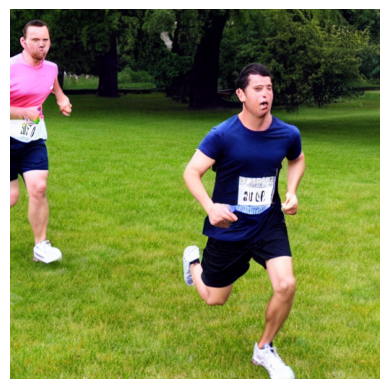

Image saved to /kaggle/working/generated_image_finetuned.png


In [8]:
# 1. Load Base Pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

# 2. Load and Apply your LoRA Adapters
# FIX: Use the pipeline's built-in method to load the LoRA weights
try:
    pipe.load_lora_weights(output_dir)
    print("LoRA adapters loaded successfully.")
except Exception as e:
    print(f"Error loading LoRA: {e}")
    # Fallback: If using older diffusers version, sometimes we need to specificy the weight name
    # pipe.load_lora_weights(output_dir, weight_name="adapter_model.bin") 

# 3. Generate Image
prompt = "man run on grass"
try:
    image = pipe(prompt, num_inference_steps=30).images[0]
    
    # Save and Display
    save_path = "/kaggle/working/generated_image_finetuned.png"
    image.save(save_path)
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print(f"Image saved to {save_path}")

except Exception as e:
    print(f"Error generating image: {e}")